<h1><center>Práctica Donativos Veterano de Guerra<center><h1>


# Integrantes

Sofía Maceín Sanz, María Araceli Pérez Buendía.

*Fecha de entrega: 23 de febrero de 2024*

# 0. Librerias

In [1]:
# Paquetes y librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

%matplotlib inline     
sns.set(color_codes=True)

Tambien hará falta descargarse, en caso de no tenerlos los paquetes:

In [ ]:
#pip install imblearn

In [2]:
import warnings

# Ignorar todas las advertencias
warnings.filterwarnings("ignore")

## Funciones auxiliares

In [3]:
# Funcion que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [4]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [5]:
# Funcion para crear el modelo 
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
    clf_base.fit(X_train, y_train)
    return clf_base

# Funcion para mostrar los resultados
def mostrar_resultados2(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels='x', yticklabels='y', annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    
    print(classification_report(y_test, pred_y))
    
    # Calcular el AUC
    auc = roc_auc_score(y_test, pred_y)
    print("AUC:", auc)
    
    # Calcular la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, pred_y)
    
    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# 1. Análisis exploratorio de los datos

## 1.1 Selección de variables. Tratamiento de missing

Vamos a comenzar con una exploración inicial de los datos para identificar posibles cambios o transformaciones necesarias.

En primer lugar, cargamos los datos y examinamos su dimensión y estructura.

In [6]:
# Lectura y copia del conjunto de datos
df = pd.read_csv("veteranos_tablaAlumnos_CSV.csv")
df_original = df.copy()

df.head(10)

,CONTROL_NUMBER_N,TARGET_B,MONTHS_SINCE_ORIGIN,DONOR_AGE,IN_HOUSE,URBANICITY,SES,CLUSTER_CODE,HOME_OWNER,DONOR_GENDER,...,LIFETIME_GIFT_RANGE,LIFETIME_MAX_GIFT_AMT,LIFETIME_MIN_GIFT_AMT,LAST_GIFT_AMT,CARD_PROM_12,NUMBER_PROM_12,MONTHS_SINCE_LAST_GIFT,MONTHS_SINCE_FIRST_GIFT,FILE_AVG_GIFT,FILE_CARD_GIFT
0,1,1,65,NaN,0,S,2,17.0,U,F,...,7.0,12.0,5.0,10.0,6,14,16,55,7.22,5
1,2,1,29,NaN,0,S,2,17.0,U,F,...,10.0,20.0,10.0,20.0,6,13,21,32,14.00,1
2,3,0,17,40.0,0,T,1,35.0,H,F,...,0.0,20.0,20.0,20.0,4,10,19,19,20.00,1
3,4,0,89,72.0,0,C,2,28.0,U,M,...,20.0,25.0,5.0,25.0,6,15,17,88,16.00,6
4,5,0,29,NaN,0,C,2,27.0,U,F,...,11.0,20.0,9.0,20.0,6,12,17,33,14.67,3
5,6,0,65,83.0,0,S,2,16.0,U,F,...,9.0,10.0,1.0,10.0,5,12,15,64,5.75,2
6,7,1,89,77.0,0,S,2,18.0,H,M,...,9.0,9.0,0.0,0.0,6,18,14,81,6.62,3
7,8,0,101,69.0,0,U,1,3.0,H,F,...,20.0,25.0,5.0,18.0,6,13,20,105,13.25,8
8,9,1,89,72.0,0,C,3,30.0,H,M,...,0.0,5.0,5.0,5.0,6,13,17,92,5.00,19
9,10,0,41,55.0,0,U,4,10.0,H,M,...,11.0,16.0,5.0,16.0,6,12,16,40,12.20,1


In [7]:
# Dimension de los datos
df.shape

(13422, 49)

Tenemos un total de 13422 registros y 49 variables.o.

In [8]:
# El conjunto de datos esta desbalanceado
df['TARGET_B'].value_counts()

0    10085
1     3337
Name: TARGET_B, dtype: int64

Vamos a analizar los tipos de variables en nuestro conjunto de datos y verificar si existen valores nulos. Esto nos permitirá tener una mejor comprensión de la calidad e integridad de los datos.

In [9]:
# Tipo de las variables y valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13422 entries, 0 to 13421
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CONTROL_NUMBER_N             13422 non-null  int64  
 1   TARGET_B                     13422 non-null  int64  
 2   MONTHS_SINCE_ORIGIN          13422 non-null  int64  
 3   DONOR_AGE                    10101 non-null  float64
 4   IN_HOUSE                     13422 non-null  int64  
 5   URBANICITY                   13422 non-null  object 
 6   SES                          13422 non-null  object 
 7   CLUSTER_CODE                 13106 non-null  float64
 8   HOME_OWNER                   13422 non-null  object 
 9   DONOR_GENDER                 13422 non-null  object 
 10  INCOME_GROUP                 10361 non-null  float64
 11  PUBLISHED_PHONE              13422 non-null  int64  
 12  OVERLAY_SOURCE               13422 non-null  object 
 13  MOR_HIT_RATE    

In [10]:
# Comprobamos si alguna columna tiene valores nulos
df.isna().any()

CONTROL_NUMBER_N               False
TARGET_B                       False
MONTHS_SINCE_ORIGIN            False
DONOR_AGE                       True
IN_HOUSE                       False
URBANICITY                     False
SES                            False
CLUSTER_CODE                    True
HOME_OWNER                     False
DONOR_GENDER                   False
INCOME_GROUP                    True
PUBLISHED_PHONE                False
OVERLAY_SOURCE                 False
MOR_HIT_RATE                   False
WEALTH_RATING                   True
MEDIAN_HOME_VALUE              False
MEDIAN_HOUSEHOLD_INCOME        False
PCT_OWNER_OCCUPIED             False
PER_CAPTITA_INCOME             False
PCT_MALE_MILITARY              False
PCT_MALE_VETERANS              False
PCT_VIETNAM_VETERANS           False
PCT_WWII_VETERANS              False
PEP_STAR                       False
RECENT_STAR_STATUS             False
RECENCY_STATUS_96NK            False
FREQUENCY_STATUS_97NK          False
R

Estudiamos las variables por las diferentes categorias

**0. IDENTIFICADOR**

* **CONTROL_NUMBER_M**

**1. TARGETS**

Podemos estudiar si la base de datos está balanceada o no.

In [11]:
# Variable target
df['TARGET_B'].value_counts()

0    10085
1     3337
Name: TARGET_B, dtype: int64

**Caracteristicas de donantes**

In [12]:
donantes = df[df['TARGET_B']==1]
donantes.head()

,CONTROL_NUMBER_N,TARGET_B,MONTHS_SINCE_ORIGIN,DONOR_AGE,IN_HOUSE,URBANICITY,SES,CLUSTER_CODE,HOME_OWNER,DONOR_GENDER,...,LIFETIME_GIFT_RANGE,LIFETIME_MAX_GIFT_AMT,LIFETIME_MIN_GIFT_AMT,LAST_GIFT_AMT,CARD_PROM_12,NUMBER_PROM_12,MONTHS_SINCE_LAST_GIFT,MONTHS_SINCE_FIRST_GIFT,FILE_AVG_GIFT,FILE_CARD_GIFT
0,1,1,65,NaN,0,S,2,17.0,U,F,...,7.0,12.0,5.0,10.0,6,14,16,55,7.22,5
1,2,1,29,NaN,0,S,2,17.0,U,F,...,10.0,20.0,10.0,20.0,6,13,21,32,14.00,1
6,7,1,89,77.0,0,S,2,18.0,H,M,...,9.0,9.0,0.0,0.0,6,18,14,81,6.62,3
8,9,1,89,72.0,0,C,3,30.0,H,M,...,0.0,5.0,5.0,5.0,6,13,17,92,5.00,19
12,13,1,65,42.0,0,R,2,48.0,H,F,...,10.0,13.0,3.0,10.0,4,10,16,64,10.22,4


In [13]:
donantes[donantes.isna().any(axis = 1)]

,CONTROL_NUMBER_N,TARGET_B,MONTHS_SINCE_ORIGIN,DONOR_AGE,IN_HOUSE,URBANICITY,SES,CLUSTER_CODE,HOME_OWNER,DONOR_GENDER,...,LIFETIME_GIFT_RANGE,LIFETIME_MAX_GIFT_AMT,LIFETIME_MIN_GIFT_AMT,LAST_GIFT_AMT,CARD_PROM_12,NUMBER_PROM_12,MONTHS_SINCE_LAST_GIFT,MONTHS_SINCE_FIRST_GIFT,FILE_AVG_GIFT,FILE_CARD_GIFT
0,1,1,65,NaN,0,S,2,17.0,U,F,...,7.0,12.0,5.0,10.0,6,14,16,55,7.22,5
1,2,1,29,NaN,0,S,2,17.0,U,F,...,10.0,20.0,10.0,20.0,6,13,21,32,14.00,1
6,7,1,89,77.0,0,S,2,18.0,H,M,...,9.0,9.0,0.0,0.0,6,18,14,81,6.62,3
20,21,1,29,NaN,0,S,2,20.0,H,F,...,10.0,20.0,10.0,20.0,4,10,19,33,15.00,1
22,23,1,137,77.0,0,T,3,41.0,U,F,...,5.0,10.0,5.0,6.0,1,5,17,112,5.77,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13372,13373,1,17,73.0,0,C,3,31.0,U,M,...,0.0,15.0,15.0,15.0,4,11,16,16,15.00,1
13379,13380,1,137,60.0,0,C,2,25.0,H,F,...,3.0,5.0,2.0,5.0,3,6,16,130,3.16,15
13391,13392,1,89,NaN,0,U,3,9.0,U,U,...,45.0,50.0,5.0,35.0,6,12,18,84,24.50,6
13401,13402,1,89,49.0,0,S,2,18.0,H,M,...,11.0,16.0,5.0,12.0,5,14,15,85,10.22,6


Estudiamos la distribución para los donantes. Así, sabremos qué características son más relevantes

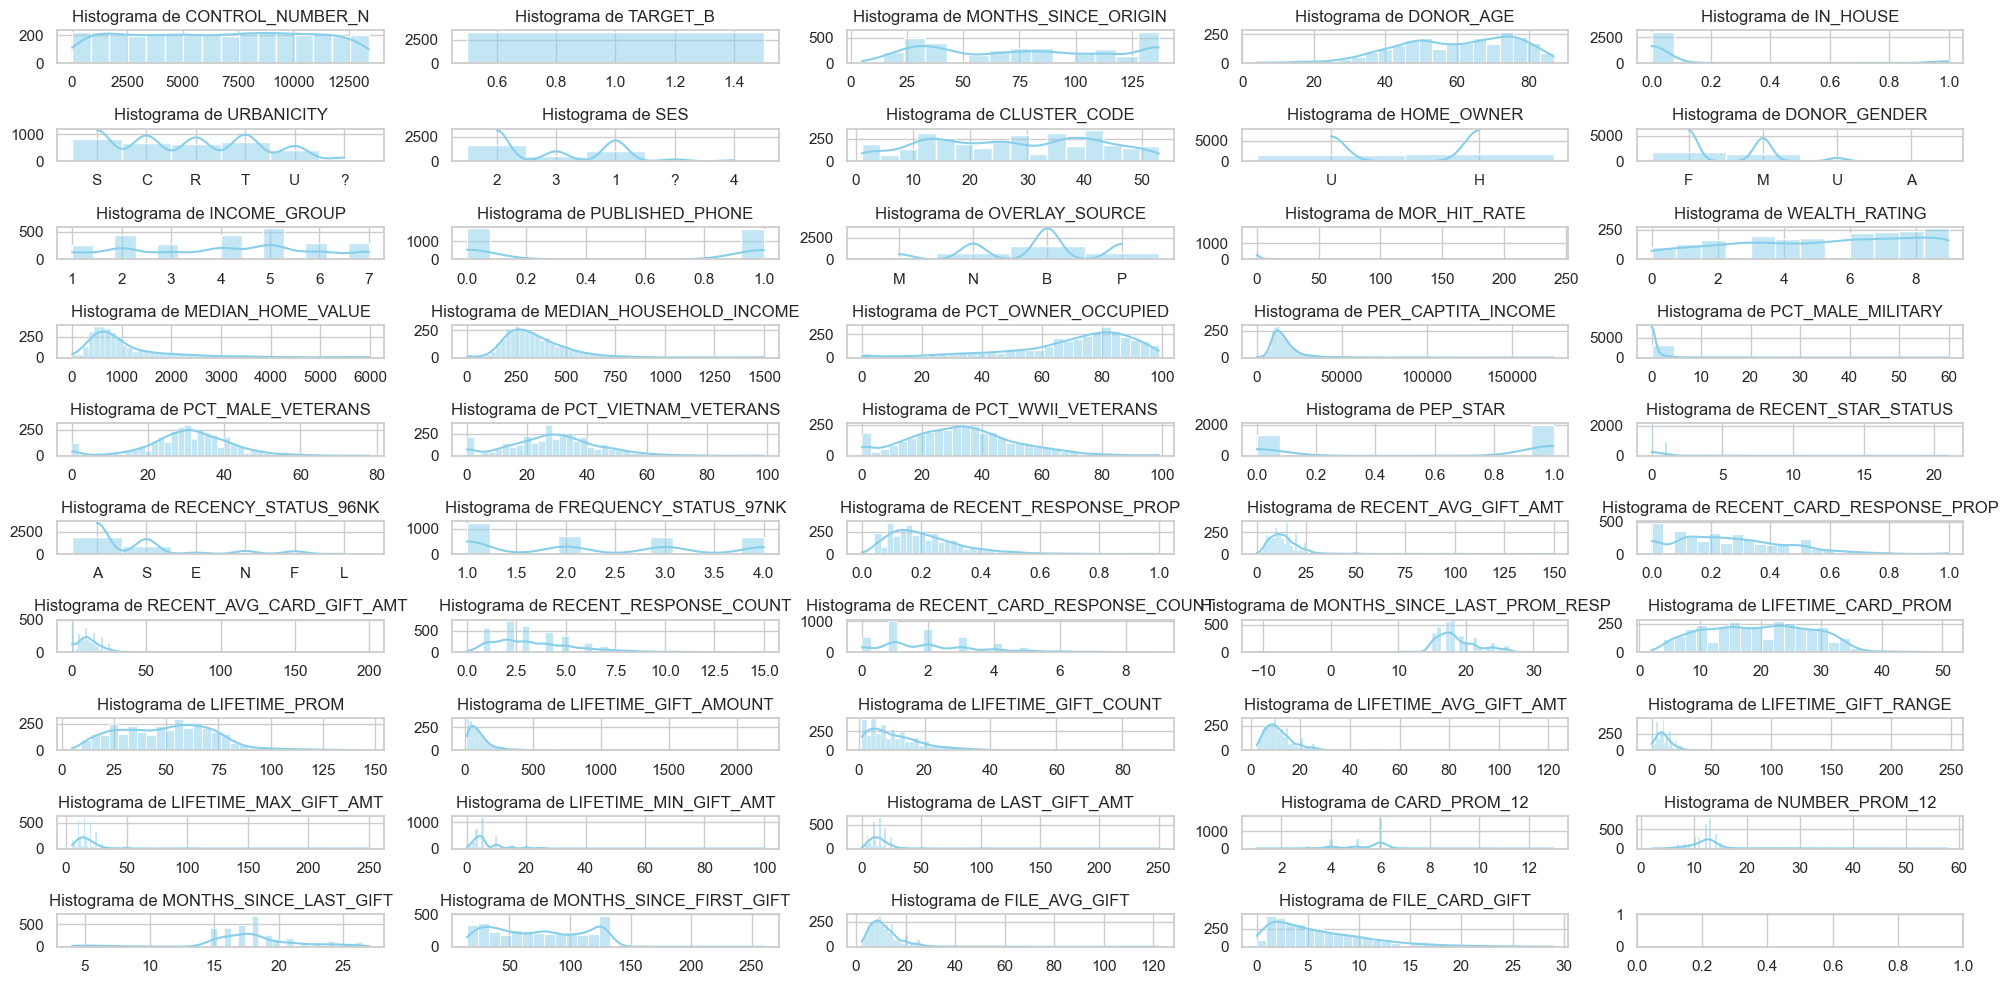

In [14]:
# Configuración de estilo
sns.set_style('whitegrid')

# Crear subplots para cada variable continua
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(20, 10))

# Crear histogramas para cada variable continua y asignar a cada subplot
for ax, column in zip(axes.flatten(), donantes.columns):
    sns.histplot(donantes[column], ax=ax, kde=True, color='skyblue')
    ax.set_title(f'Histograma de {column}')
    ax.set_xlabel('')
    ax.set_ylabel('')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

La base de datos está desbalanceada. Tendremos que tener esto en cuenta posteriormente a la hora de aplicar los diferentes modelos, utilizando tecnicas de muestreo.

**2. DATOS COLABORADORES**

In [15]:
colaboradores = df[['TARGET_B','MONTHS_SINCE_ORIGIN','IN_HOUSE']]

colaboradores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13422 entries, 0 to 13421
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   TARGET_B             13422 non-null  int64
 1   MONTHS_SINCE_ORIGIN  13422 non-null  int64
 2   IN_HOUSE             13422 non-null  int64
dtypes: int64(3)
memory usage: 314.7 KB


**3. DATOS DEMOGRÁFICOS**

In [16]:
demograficos = df[['SES', 'CLUSTER_CODE', 'HOME_OWNER','DONOR_GENDER',
                   'DONOR_AGE', 'INCOME_GROUP', 'PUBLISHED_PHONE', 
                   'OVERLAY_SOURCE', 'MOR_HIT_RATE', 'WEALTH_RATING', 
                   'MEDIAN_HOME_VALUE','MEDIAN_HOUSEHOLD_INCOME',
                   'PCT_OWNER_OCCUPIED', 'PER_CAPTITA_INCOME']]

Del primer grupo nos quedamos con: 
* `DONOR_AGE`: Tiene missing
* `DONOR_GENDER`: Eliminamos la observacion que tiene como valor 'A'
* `HOME_OWNER`: No tiene missing

In [17]:
# Mas variables a eliminar
eliminar = ['OVERLAY_SOURCE']
eliminar.append('PUBLISHED_PHONE')
eliminar.append('MOR_HIT_RATE')

In [18]:
demograficos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13422 entries, 0 to 13421
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SES                      13422 non-null  object 
 1   CLUSTER_CODE             13106 non-null  float64
 2   HOME_OWNER               13422 non-null  object 
 3   DONOR_GENDER             13422 non-null  object 
 4   DONOR_AGE                10101 non-null  float64
 5   INCOME_GROUP             10361 non-null  float64
 6   PUBLISHED_PHONE          13422 non-null  int64  
 7   OVERLAY_SOURCE           13422 non-null  object 
 8   MOR_HIT_RATE             13422 non-null  int64  
 9   WEALTH_RATING            7314 non-null   float64
 10  MEDIAN_HOME_VALUE        13422 non-null  int64  
 11  MEDIAN_HOUSEHOLD_INCOME  13422 non-null  int64  
 12  PCT_OWNER_OCCUPIED       13422 non-null  int64  
 13  PER_CAPTITA_INCOME       13422 non-null  int64  
dtypes: float64(4), int64(6

DONOR_GENDER: 
 F    7214
M    5492
U     715
A       1
Name: DONOR_GENDER, dtype: int64

 HOME_OWNER: 
 H    7310
U    6112
Name: HOME_OWNER, dtype: int64


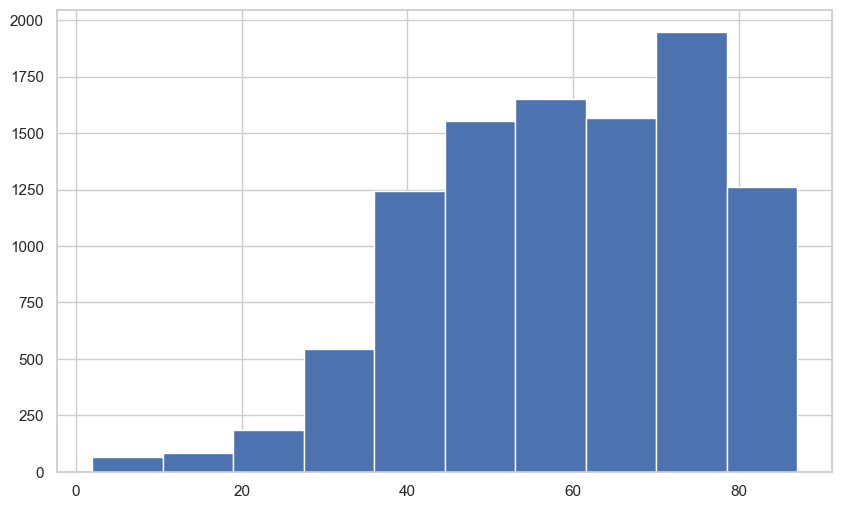

In [19]:
# Exploracion previa
demograficos['DONOR_AGE'].hist(figsize=(10, 6))

print('DONOR_GENDER: \n', demograficos['DONOR_GENDER'].value_counts())

print('\n HOME_OWNER: \n', demograficos['HOME_OWNER'].value_counts())

In [20]:
# Cambiamos una fila
demograficos.loc[demograficos['DONOR_GENDER'] == 'A', 'DONOR_GENDER'] = 'U'
df.loc[df['DONOR_GENDER'] == 'A', 'DONOR_GENDER'] = 'U'

Posibles variables de estudio:
* `CLUSTER_CODE`, `SES`, `WEALTH_RATING` y `INCOME_GROUP` son variables de agrupación socio-económica. Podemos estudiar relación entre ellas y eliminar variables redundantes o utilizarlas para imputar missing en caso en que haya entre ellas

* `MEDIAN_HOUSEHOLD_INCOME`, `PER_CAPITA_INCOME`, `MEDIAN_HOME_VALUE`. son variable de ingresos por capita/zona.

* `URBANICIRY` clasificación del domiciolio individual.

* `PCT_ ` son variables que miden el porcentaje de militares/veteranos en el vecindario.

In [21]:
demograficos['SES'].unique()

array(['2', '1', '3', '4', '?'], dtype=object)

In [22]:
# Podemos tratar de imputar la variable con lo que conocemos
df[df['SES']=='?'][['SES','MEDIAN_HOUSEHOLD_INCOME','PER_CAPTITA_INCOME']].isna().any()

SES                        False
MEDIAN_HOUSEHOLD_INCOME    False
PER_CAPTITA_INCOME         False
dtype: bool

In [23]:
# Convertimos '?' a pd.NA 
demograficos['SES'] = pd.to_numeric(demograficos['SES'], errors='coerce')

# Convertimos 'SES' a float64
demograficos['SES'] = demograficos['SES'].astype(float)

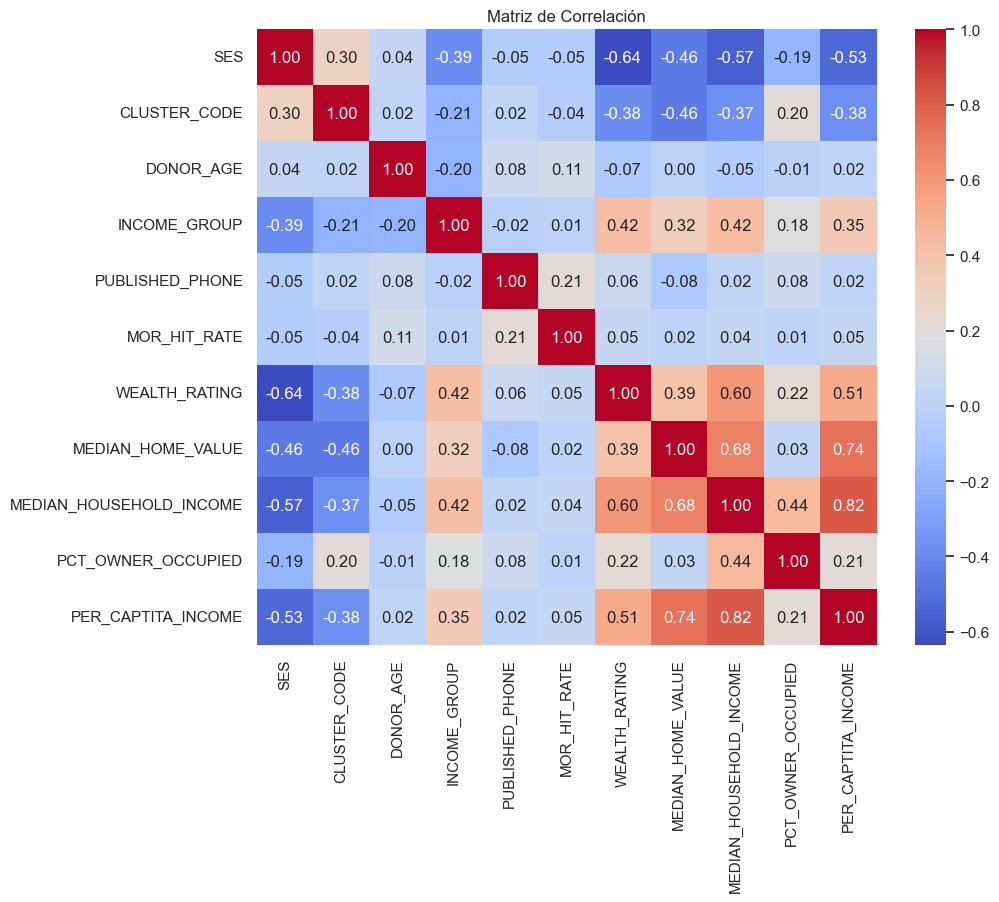

In [24]:
# Calcular la matriz de correlación
correlation_matrix = demograficos.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Como `SES`está muy correlada con `INCOME_GROUP` y `WEALTH_RATING`que presenta un alto porcentaje de valores missing, eliminamos estas variables del modelo. Además, también eliminamos`CLUSTER_CODE` pues se trata de otra variable de agrupación socio-economica que presenta missing cuando `SES` presenta missing. 

In [25]:
# Mas variables a eliminar
eliminar.append('CLUSTER_CODE')
eliminar.append('WEALTH_RATING')
eliminar.append('INCOME_GROUP')

* Estudiamos los valores missing para imputar la variable `SES`

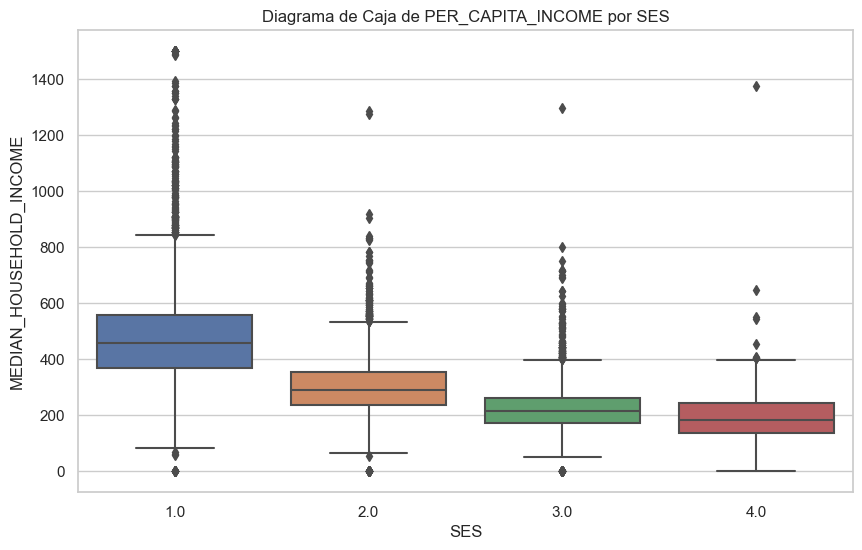

In [26]:
# Diagrama de caja
plt.figure(figsize=(10, 6))
sns.boxplot(x='SES', y='MEDIAN_HOUSEHOLD_INCOME', data=demograficos)
plt.title('Diagrama de Caja de PER_CAPITA_INCOME por SES')
plt.show()

In [27]:
medianas_por_ses = demograficos.groupby('SES')['MEDIAN_HOUSEHOLD_INCOME'].median()
print('Medianas: \n', medianas_por_ses)

income_ses = demograficos.groupby('SES')['PER_CAPTITA_INCOME'].mean()
print('\n Medias income: \n', income_ses)

Medianas: 
 SES
1.0    457.0
2.0    290.0
3.0    214.0
4.0    184.0
Name: MEDIAN_HOUSEHOLD_INCOME, dtype: float64

 Medias income: 
 SES
1.0    23153.039129
2.0    13477.441925
3.0    10454.347204
4.0     9208.955556
Name: PER_CAPTITA_INCOME, dtype: float64


In [28]:
limses1 = medianas_por_ses[1]
limses2 = medianas_por_ses[2]
limses3 = medianas_por_ses[3]
limses4 = medianas_por_ses[4]

demograficos.loc[demograficos['SES'].isna() & (demograficos['MEDIAN_HOUSEHOLD_INCOME'] < limses4), 'SES'] = 4
demograficos.loc[demograficos['SES'].isna() & (demograficos['MEDIAN_HOUSEHOLD_INCOME'] >= limses4) & (demograficos['MEDIAN_HOUSEHOLD_INCOME'] < limses3), 'SES'] = 3
demograficos.loc[demograficos['SES'].isna() & (demograficos['MEDIAN_HOUSEHOLD_INCOME'] >= limses3) & (demograficos['MEDIAN_HOUSEHOLD_INCOME'] < limses2), 'SES'] = 3
demograficos.loc[demograficos['SES'].isna() & (demograficos['MEDIAN_HOUSEHOLD_INCOME'] >= limses2) & (demograficos['MEDIAN_HOUSEHOLD_INCOME'] < limses1), 'SES'] = 2
demograficos.loc[demograficos['SES'].isna() & (demograficos['MEDIAN_HOUSEHOLD_INCOME'] >= limses1), 'SES'] = 1

# Verificar que ya no haya valores faltantes en SES
print(demograficos['SES'].isnull().sum())

0


In [29]:
# Cambiamos por la variable imputda
df.drop('SES', axis = 1, inplace = True)
df['SES'] = demograficos['SES']

<Axes: >

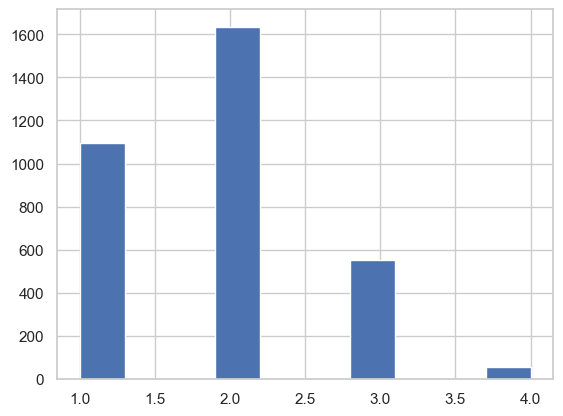

In [30]:
# Comprobamos que no haya cambiado la distribucion
df[df['TARGET_B']==1]['SES'].hist()

* `PER_CAPITA_INCOME`

Para los valores que son 0, asignamos el valor medio de `PER_CAPITA_INCOME` agrupando por `SES`.

Text(0, 0.5, 'Ingreso Mediano del Hogar')

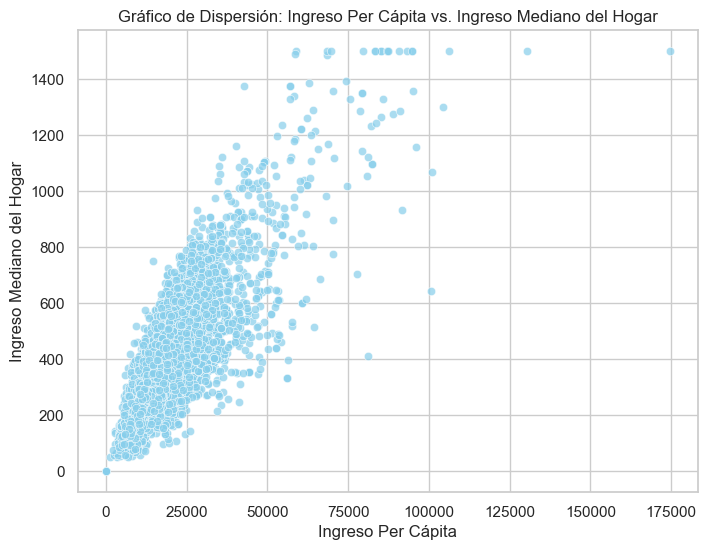

In [31]:
# Configuración de estilo
sns.set_style('whitegrid')

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['PER_CAPTITA_INCOME'], y=df['MEDIAN_HOUSEHOLD_INCOME'], color='skyblue', alpha=0.7)
plt.title('Gráfico de Dispersión: Ingreso Per Cápita vs. Ingreso Mediano del Hogar')
plt.xlabel('Ingreso Per Cápita')
plt.ylabel('Ingreso Mediano del Hogar')

In [35]:
media_por_ses = demograficos.groupby('SES')['PER_CAPTITA_INCOME'].mean()
media_por_ses

SES
1.0    23174.155052
2.0    13525.924897
3.0    10531.040017
4.0     8963.646667
Name: PER_CAPTITA_INCOME, dtype: float64

In [37]:
# Calcular las medias agrupadas por SES
mediana_por_ses = demograficos.groupby('SES')['PER_CAPTITA_INCOME'].median()

# Crear un subDataFrame con los valores de PER_CAPTITA_INCOME igual a 0
sub_df = demograficos[demograficos['PER_CAPTITA_INCOME'] == 0]

# Asignar las medias agrupadas por SES a los valores de PER_CAPTITA_INCOME igual a 0
for ses, mediana in mediana_por_ses.items():
    sub_df.loc[sub_df['SES'] == ses, 'PER_CAPTITA_INCOME'] = mediana

# Actualizar el DataFrame original con los cambios
demograficos.update(sub_df)

# Verificar que los valores se hayan actualizado correctamente
print(demograficos[demograficos['PER_CAPTITA_INCOME'] == 0])

Empty DataFrame
Columns: [SES, CLUSTER_CODE, HOME_OWNER, DONOR_GENDER, DONOR_AGE, INCOME_GROUP, PUBLISHED_PHONE, OVERLAY_SOURCE, MOR_HIT_RATE, WEALTH_RATING, MEDIAN_HOME_VALUE, MEDIAN_HOUSEHOLD_INCOME, PCT_OWNER_OCCUPIED, PER_CAPTITA_INCOME]
Index: []


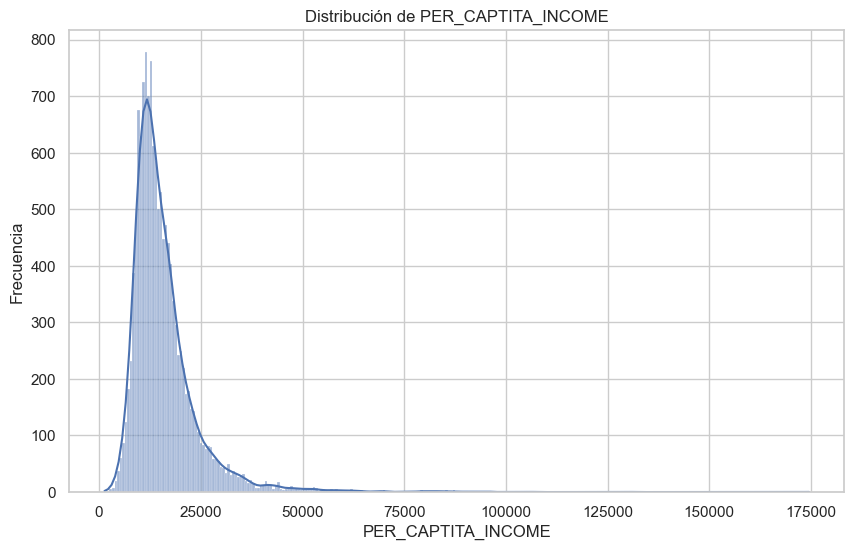

In [38]:
# Histograma de la variable PER_CAPTITA_INCOME
plt.figure(figsize=(10, 6))
sns.histplot(demograficos['PER_CAPTITA_INCOME'], kde=True)
plt.title('Distribución de PER_CAPTITA_INCOME')
plt.xlabel('PER_CAPTITA_INCOME')
plt.ylabel('Frecuencia')
plt.show()

In [39]:
# Cambiamos por la variable imputda
df.drop('PER_CAPTITA_INCOME', axis = 1, inplace = True)
df['PER_CAPTITA_INCOME'] = demograficos['PER_CAPTITA_INCOME']

In [40]:
# Mas variables a eliminar
eliminar.append('MEDIAN_HOUSEHOLD_INCOME')
eliminar.append('MEDIAN_HOME_VALUE')

* `DONOR_AGE`

In [43]:
print(df['DONOR_AGE'].describe())

# Imputamos por O - asi podemos saber luego con un arbol si la clase
# missing es relevante
df['DONOR_AGE'] = df['DONOR_AGE'].fillna(0)

count    10101.000000
mean        58.843877
std         16.682388
min          2.000000
25%         47.000000
50%         60.000000
75%         73.000000
max         87.000000
Name: DONOR_AGE, dtype: float64


<Axes: >

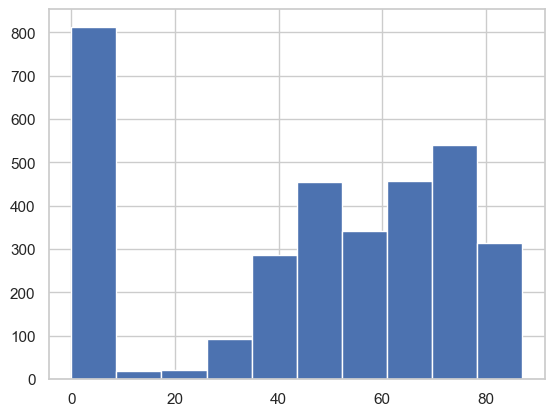

In [44]:
# Parece una variable importante, cuando es missing hay muchos donantes
df[df['TARGET_B']==1]['DONOR_AGE'].hist()

De esta sección nos quedamos con las variables: `SES`, `CLUSTER_CODE`, `PER_CAPTITA_INCOME`, `PCT_OWNER_OCCUPIED` imputadas

**4. DATOS CENSALES**

In [48]:
censales = df[['TARGET_B','URBANICITY', 'PCT_MALE_MILITARY', 'PCT_MALE_VETERANS', 'PCT_VIETNAM_VETERANS',
       'PCT_WWII_VETERANS']]

array([[<Axes: title={'center': 'PCT_MALE_VETERANS'}>,
        <Axes: title={'center': 'PCT_VIETNAM_VETERANS'}>],
       [<Axes: title={'center': 'PCT_WWII_VETERANS'}>, <Axes: >]],
      dtype=object)

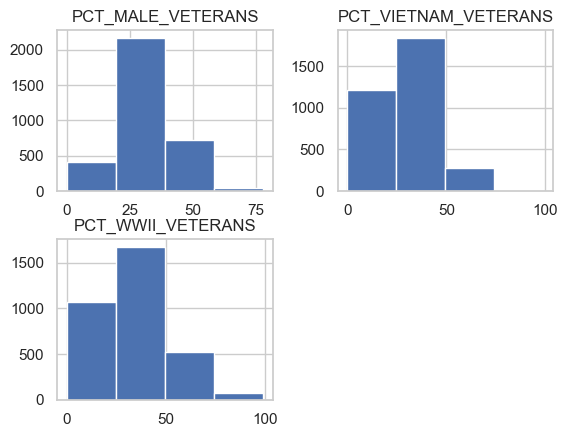

In [62]:
# Podria ir bien un woe-encodig hay una clara estructura
censales[censales['TARGET_B']==1][['PCT_MALE_VETERANS', 'PCT_VIETNAM_VETERANS',
       'PCT_WWII_VETERANS']].hist(bins=4)

In [46]:
censales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13422 entries, 0 to 13421
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   URBANICITY            13422 non-null  object
 1   PCT_MALE_MILITARY     13422 non-null  int64 
 2   PCT_MALE_VETERANS     13422 non-null  int64 
 3   PCT_VIETNAM_VETERANS  13422 non-null  int64 
 4   PCT_WWII_VETERANS     13422 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 524.4+ KB


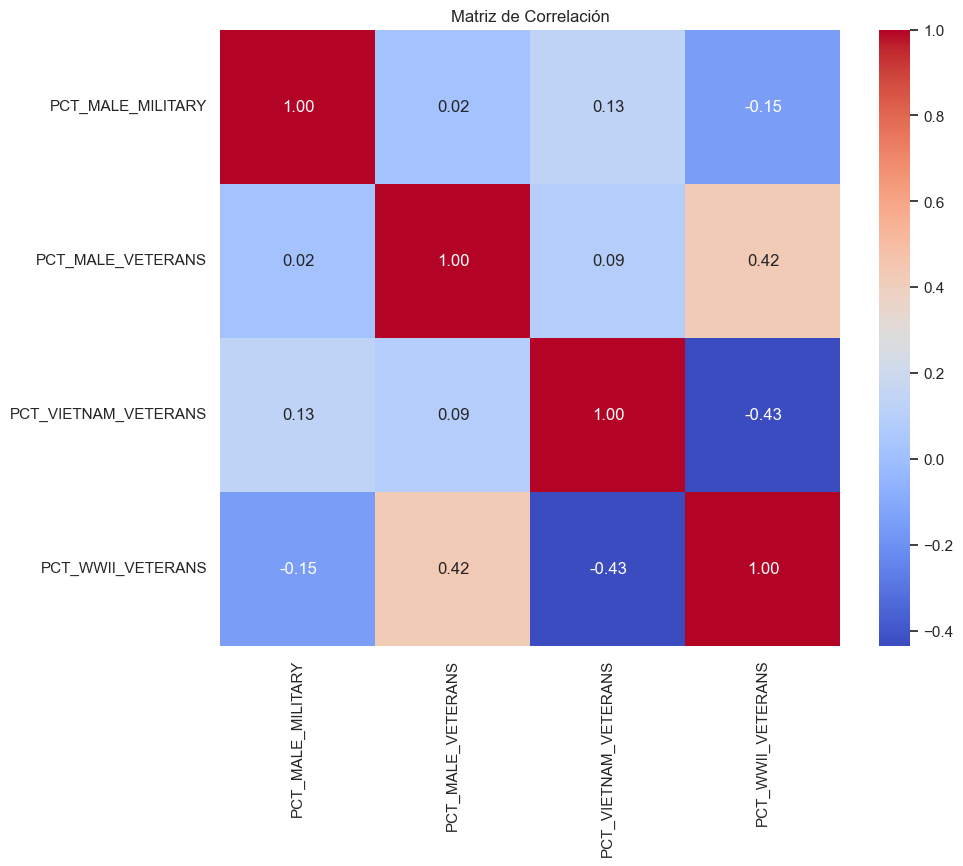

In [47]:
# Calcular la matriz de correlación
correlation_matrix = censales.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Parece que la variable `PCT_WWII_VETERANS` esta correlada con el resto. Nos quedamos con ella y con `PCT_MALE_MILITARY`

In [63]:
# Mas variables a eliminar
eliminar.append('PCT_MALE_MILITARY')
eliminar.append('PCT_MALE_VETERANS')
eliminar.append('PCT_VIETNAM_VETERANS')

**5. TRANSACCIONES**

In [66]:
transacciones = df[['TARGET_B','CARD_PROM_12', 'NUMBER_PROM_12','FREQUENCY_STATUS_97NK',
                  'MONTHS_SINCE_LAST_PROM_RESP','LAST_GIFT_AMT',
                  'RECENT_RESPONSE_PROP',
       'RECENT_AVG_GIFT_AMT', 'RECENT_CARD_RESPONSE_PROP',
       'RECENT_AVG_CARD_GIFT_AMT', 'RECENT_RESPONSE_COUNT',
       'RECENT_CARD_RESPONSE_COUNT',
                   'LIFETIME_CARD_PROM', 'LIFETIME_PROM', 'LIFETIME_GIFT_AMOUNT',
       'LIFETIME_GIFT_COUNT', 'LIFETIME_AVG_GIFT_AMT', 'LIFETIME_GIFT_RANGE',
       'LIFETIME_MAX_GIFT_AMT', 'LIFETIME_MIN_GIFT_AMT',
     'MONTHS_SINCE_LAST_GIFT',
       'MONTHS_SINCE_FIRST_GIFT', 'FILE_AVG_GIFT', 'FILE_CARD_GIFT'
                  ]]

In [67]:
transacciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13422 entries, 0 to 13421
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TARGET_B                     13422 non-null  int64  
 1   CARD_PROM_12                 13422 non-null  int64  
 2   NUMBER_PROM_12               13422 non-null  int64  
 3   FREQUENCY_STATUS_97NK        13422 non-null  int64  
 4   MONTHS_SINCE_LAST_PROM_RESP  13252 non-null  float64
 5   LAST_GIFT_AMT                13422 non-null  float64
 6   RECENT_RESPONSE_PROP         13422 non-null  float64
 7   RECENT_AVG_GIFT_AMT          13422 non-null  float64
 8   RECENT_CARD_RESPONSE_PROP    13422 non-null  float64
 9   RECENT_AVG_CARD_GIFT_AMT     13422 non-null  float64
 10  RECENT_RESPONSE_COUNT        13422 non-null  int64  
 11  RECENT_CARD_RESPONSE_COUNT   13422 non-null  int64  
 12  LIFETIME_CARD_PROM           13422 non-null  int64  
 13  LIFETIME_PROM   

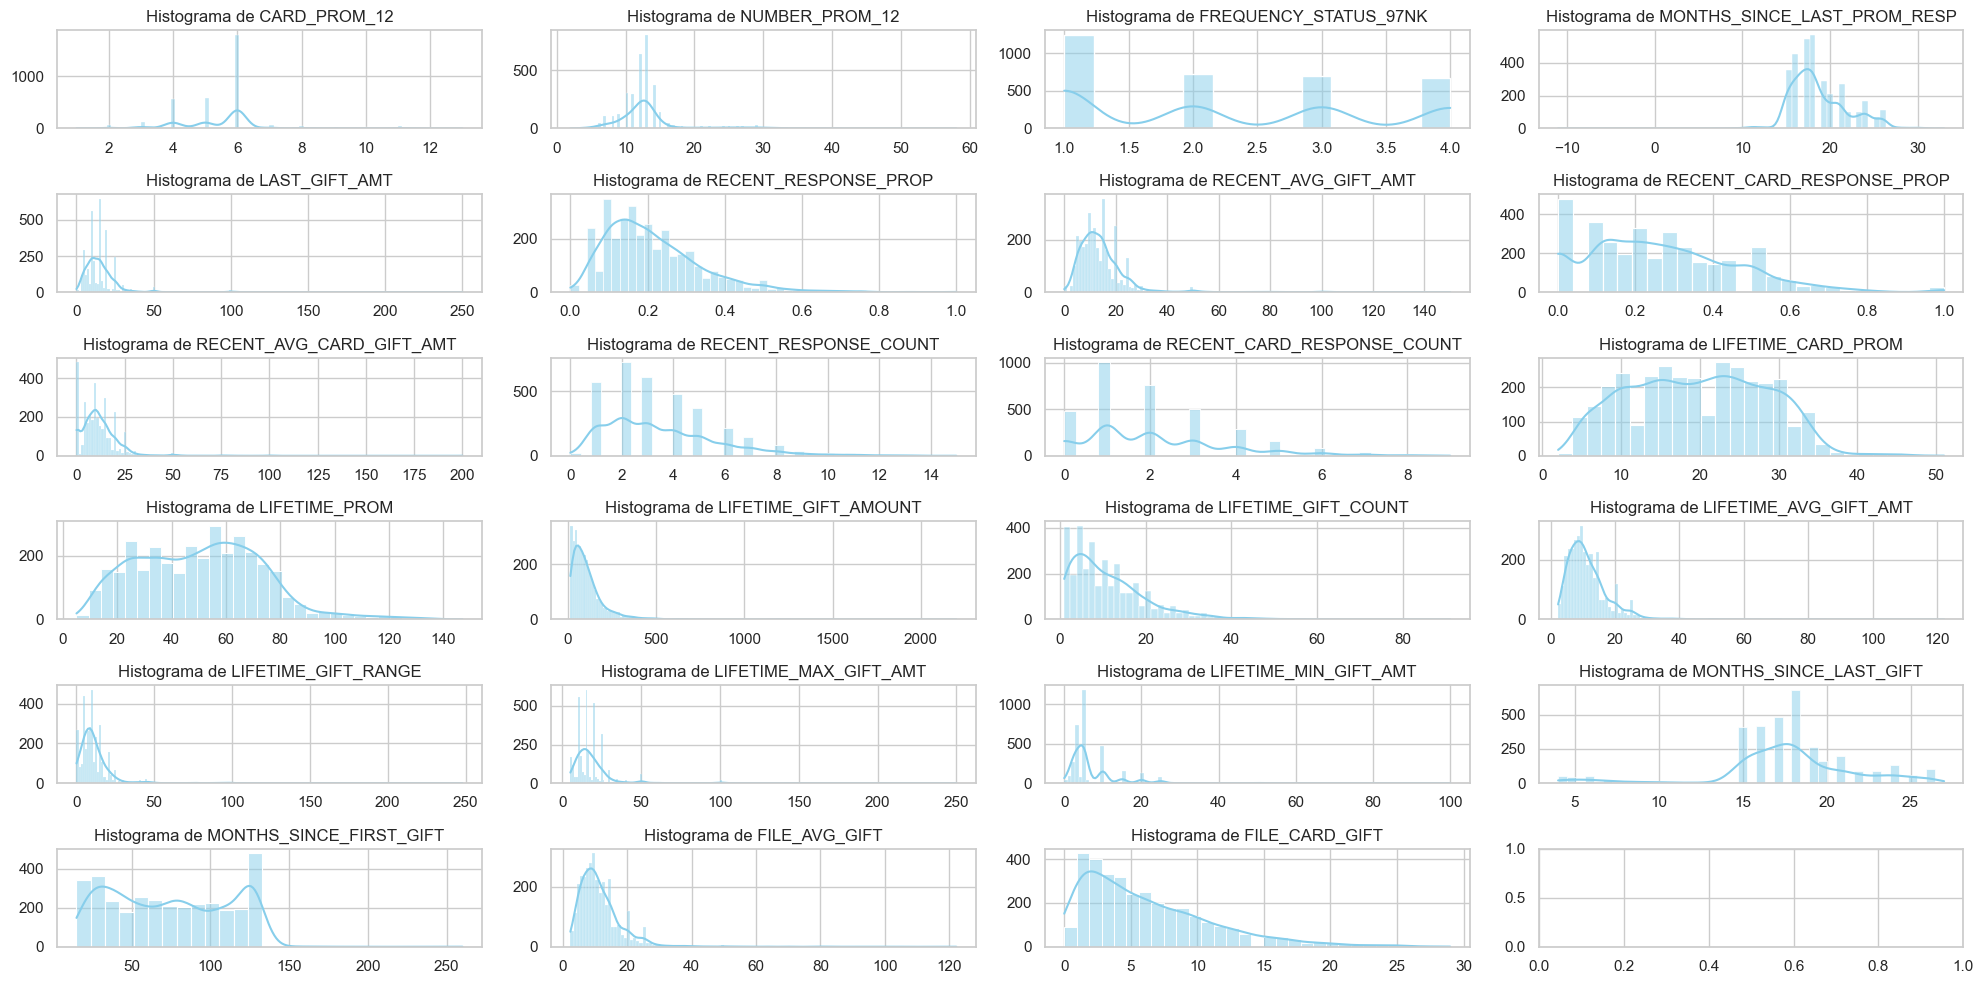

In [72]:
donantes = transacciones[transacciones['TARGET_B']==1].drop('TARGET_B', axis = 1)

# Configuración de estilo
sns.set_style('whitegrid')

# Crear subplots para cada variable continua
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 10))

# Crear histogramas para cada variable continua y asignar a cada subplot
for ax, column in zip(axes.flatten(), donantes.columns):
    sns.histplot(donantes[column], ax=ax, kde=True, color='skyblue')
    ax.set_title(f'Histograma de {column}')
    ax.set_xlabel('')
    ax.set_ylabel('')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

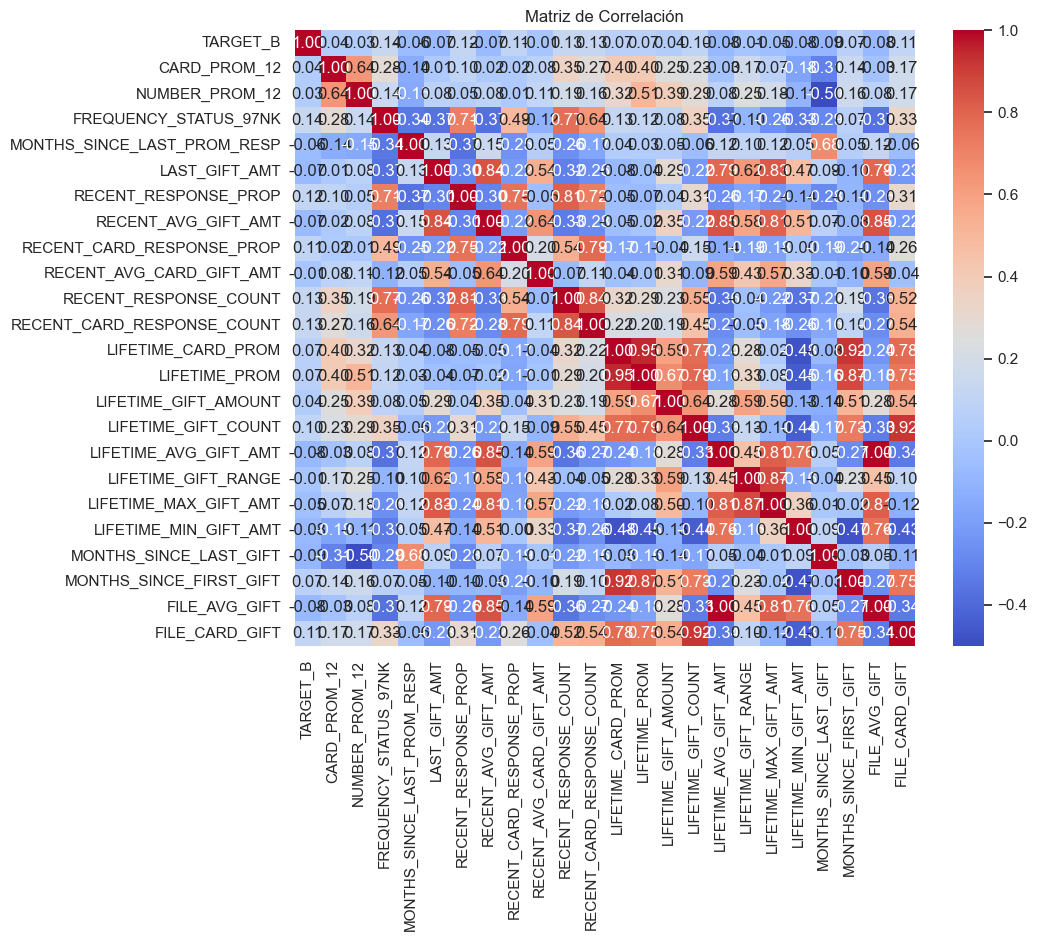

In [73]:
# Calcular la matriz de correlación
correlation_matrix = transacciones.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

De esta sección, sólo `MONTHS_SINCE_LAST_PROM_RESP` presenta valores missing, los imputamos.

In [74]:
print(df[['MONTHS_SINCE_LAST_PROM_RESP', 'MONTHS_SINCE_LAST_GIFT']])

# Imputar 'MONTHS_SINCE_LAST_PROM_RESP' con 'MONTHS_SINCE_LAST_GIFT'
df['MONTHS_SINCE_LAST_PROM_RESP'].fillna(df['MONTHS_SINCE_LAST_GIFT'], inplace=True)

       MONTHS_SINCE_LAST_PROM_RESP  MONTHS_SINCE_LAST_GIFT
0                             16.0                      16
1                             21.0                      21
2                             19.0                      19
3                             17.0                      17
4                             17.0                      17
...                            ...                     ...
13417                         16.0                      16
13418                         16.0                      16
13419                         18.0                      18
13420                         16.0                      16
13421                         18.0                      18

[13422 rows x 2 columns]


De esta sección nos quedamos con:
`CARD_PROM_12`, `FREQUENCY_STATUS_97NK`, `RECENT_CARD_RESPONSE_COUNT`,`LIFETIME_AVG_GIFT_AMT` `MONTHS_BTW_GIFT` y `FILE_CARD_GIFT`

In [76]:
MONTHS_BTW_GIFT = df['MONTHS_SINCE_FIRST_GIFT'] - df['MONTHS_SINCE_LAST_GIFT']
df['MONTHS_BTW_GIFT'] = MONTHS_BTW_GIFT 
                                                      
# Mas variables a eliminar
eliminar.append('NUMBER_PROM_12')
eliminar.append('MONTHS_SINCE_LAST_PROM_RESP')
eliminar.append('LAST_GIFT_AMT')
eliminar.append('RECENT_RESPONSE_PROP')
eliminar.append('RECENT_AVG_GIFT_AMT')
eliminar.append('RECENT_CARD_RESPONSE_PROP')
eliminar.append('RECENT_AVG_CARD_GIFT_AMT')
eliminar.append('RECENT_RESPONSE_COUNT')
eliminar.append('RECENT_RESPONSE_COUNT')
eliminar.append('LIFETIME_CARD_PROM')
eliminar.append('LIFETIME_PROM')
eliminar.append('LIFETIME_GIFT_AMOUNT')
eliminar.append('LIFETIME_GIFT_COUNT')
eliminar.append('LIFETIME_GIFT_RANGE') 
eliminar.append('LIFETIME_MAX_GIFT_AMT')
eliminar.append('LIFETIME_MIN_GIFT_AMT')
eliminar.append('MONTHS_SINCE_LAST_GIFT')
eliminar.append('MONTHS_SINCE_FIRST_GIFT')
eliminar.append('FILE_AVG_GIFT')                          

Eliminamos las variables

In [77]:
# Eliminar las columnas del DataFrame df
df.drop(eliminar, axis=1, inplace=True)

In [78]:
# Comprobamos que no haya varibales con valores missing
df.isna().any()

CONTROL_NUMBER_N              False
TARGET_B                      False
MONTHS_SINCE_ORIGIN           False
DONOR_AGE                     False
IN_HOUSE                      False
URBANICITY                    False
HOME_OWNER                    False
DONOR_GENDER                  False
PCT_OWNER_OCCUPIED            False
PCT_WWII_VETERANS             False
PEP_STAR                      False
RECENT_STAR_STATUS            False
RECENCY_STATUS_96NK           False
FREQUENCY_STATUS_97NK         False
RECENT_CARD_RESPONSE_COUNT    False
LIFETIME_AVG_GIFT_AMT         False
CARD_PROM_12                  False
FILE_CARD_GIFT                False
SES                           False
PER_CAPTITA_INCOME            False
MONTHS_BTW_GIFT               False
dtype: bool

## 1.2 Tratamiento de outliers

## 1.3 Selección de variables

Hacemos un **Random Forest** para ver qué variables son más importantes para el modelo

In [79]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [81]:
# Matriz de observaciones
X = df.drop(['TARGET_B', 'CONTROL_NUMBER_N'], axis=1)  # Excluir 'TARGET_B' y 'CONTROL_NUMBER_N'
X['IN_HOUSE'] = X['IN_HOUSE'].astype(str)
X['SES'] = X['SES'].astype(str)
X['PEP_STAR'] = X['PEP_STAR'].astype(str)
X = pd.get_dummies(X)

# Variable target
y = df['TARGET_B'].copy()

# Random forest para selección de características
clf_rnd = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
clf_rnd.fit(X, y)

# Seleccionamos las caracteristicas mas importantes
feature_importances = {name: score for name, score in zip(list(X), clf_rnd.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)

print(feature_importances_sorted)

PER_CAPTITA_INCOME            0.114037
LIFETIME_AVG_GIFT_AMT         0.102994
PCT_OWNER_OCCUPIED            0.098168
PCT_WWII_VETERANS             0.095903
MONTHS_BTW_GIFT               0.086405
DONOR_AGE                     0.081254
FILE_CARD_GIFT                0.054152
MONTHS_SINCE_ORIGIN           0.041012
RECENT_CARD_RESPONSE_COUNT    0.038938
CARD_PROM_12                  0.038369
FREQUENCY_STATUS_97NK         0.027764
DONOR_GENDER_F                0.014762
DONOR_GENDER_M                0.014558
RECENT_STAR_STATUS            0.014271
HOME_OWNER_U                  0.013938
SES_2.0                       0.013882
URBANICITY_T                  0.013303
HOME_OWNER_H                  0.013224
URBANICITY_S                  0.012715
URBANICITY_C                  0.012698
SES_1.0                       0.011106
URBANICITY_R                  0.010223
URBANICITY_U                  0.009878
SES_3.0                       0.009671
RECENCY_STATUS_96NK_A         0.007129
DONOR_GENDER_U           

# 2. División de los datos

### Balanceo y división de los datos

Para evitar que el sesgo de los datos influya en la capacidad predictiva de los modelos, debemos comprobar si este existe y, en caso de hacerlo, corregirlo.

Importamos lo paquetes necesarios para este apartado.

In [82]:
# Librerias
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

from collections import Counter

Comprobamos la proporción de datos que existen con cada etiqueta, es decir, la proporción entre abandonos y continuidad en la empresa.

In [83]:
df['TARGET_B'].value_counts()

0    10085
1     3337
Name: TARGET_B, dtype: int64

Se ve claramente que los datos están desbalanceados, concretamente hay un 24,86% de gente que acepta la petición de donación. Sin embargo, la correción no se hará sobre todo el dataset si no que, lo aplicaremos solo sobre los datos de entrenamiento de los modelos.

Dividmos el conjunto de datos en entrenamiento, validación y test

In [84]:
# Dividimos el conjunto de datos
data = pd.concat([y, X], axis=1)
train_set, val_set, test_set = train_val_test_split(data)

X_train, y_train = remove_labels(train_set, 'TARGET_B')
X_val, y_val = remove_labels(val_set, 'TARGET_B')
X_test, y_test = remove_labels(test_set, 'TARGET_B')

Probamos diferentes tipos de balanceo de los datos

* **Sin estrategia**

En primer lugar, ajustamos un modelo de regresión logística "desbalanceado" para ver los resultados que obtenemos y poder tener unas métricas para comparar.

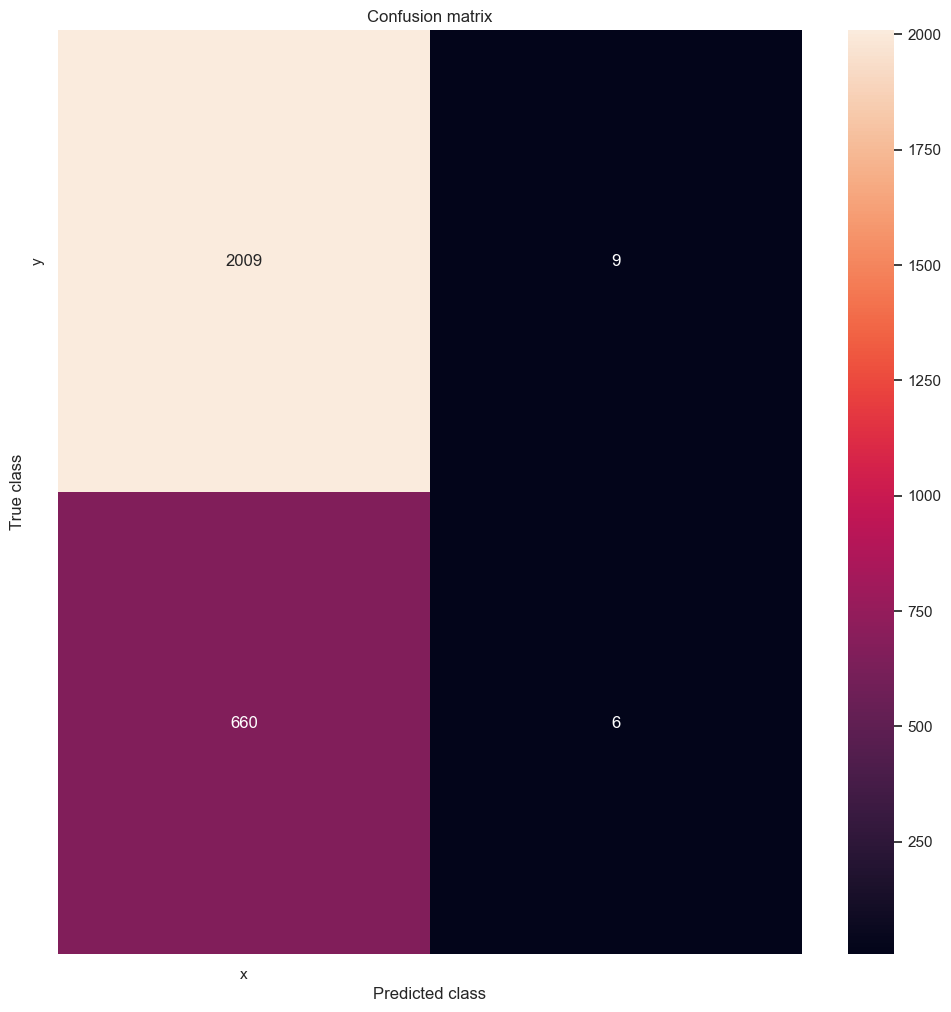

              precision    recall  f1-score   support

           0       0.75      1.00      0.86      2018
           1       0.40      0.01      0.02       666

    accuracy                           0.75      2684
   macro avg       0.58      0.50      0.44      2684
weighted avg       0.67      0.75      0.65      2684

AUC: 0.5022745738801239


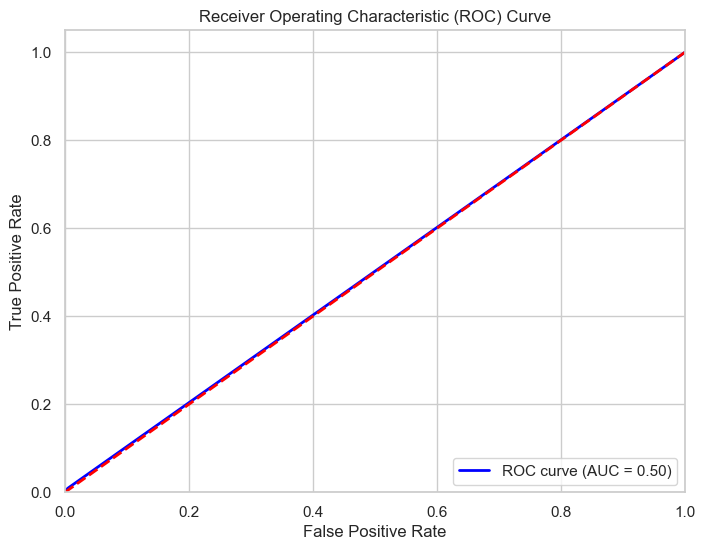

In [85]:
# Modelo
model = run_model(X_train, X_val, y_train, y_val)

# Predicciones
pred_y = model.predict(X_val)

# Resultados
mostrar_resultados2(y_val, pred_y)

Si nos fijamos en la matriz de confusión en la clase minoritaria vemos que existen 661 fallos y 5 aciertos. Obviamente, el recall que obtenemos es muy bajo (que es el valor que queremos mejorar). Por tanto, este modelo NO es capaz de predecir cuando una persona acepta la propuesta.

* **Penalización para compensar**

Ajustamos un modelo de regresión logística que balancee de forma autónoma los datos de entrenamiento. Para ello, añadimos el parámetro class_weight = 'balanced'.

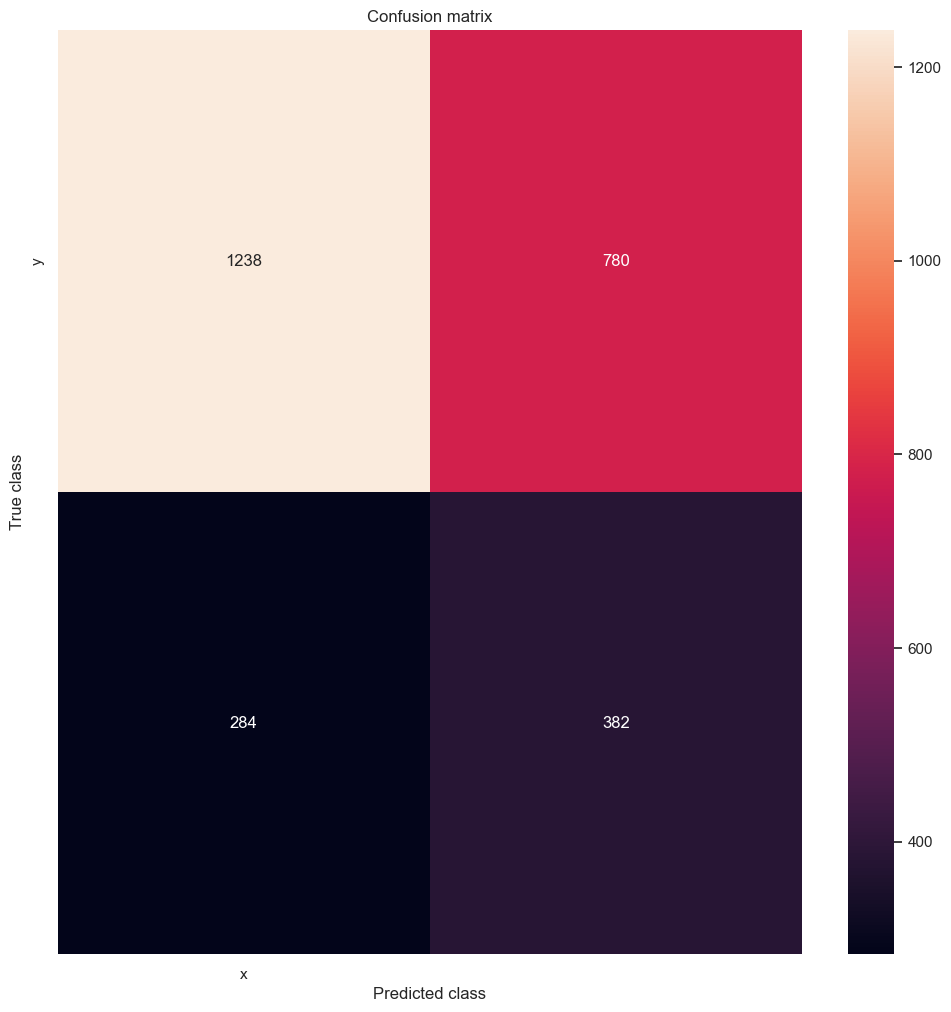

              precision    recall  f1-score   support

           0       0.81      0.61      0.70      2018
           1       0.33      0.57      0.42       666

    accuracy                           0.60      2684
   macro avg       0.57      0.59      0.56      2684
weighted avg       0.69      0.60      0.63      2684

AUC: 0.5935261326738036


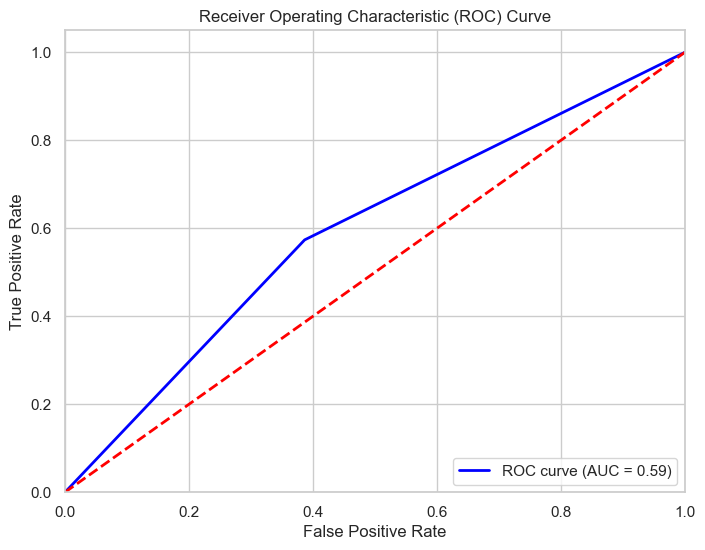

In [86]:
# Funcion
def run_model_balanced(X_train, X_val, y_train, y_val):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=0,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

# Modelo
model = run_model_balanced(X_train, X_val, y_train, y_val)

# Predicciones
pred_y = model.predict(X_val)

# Resultados
mostrar_resultados2(y_val, pred_y)

Como podemos ver en la matriz de confusión obtenemos, para la clase minoritaria , 288 fallos y 378 aciertos y un recall de 0.57. Esto es considerablemente mejor que el modelo anterior, pues ahora nuestro modelo es capaz de predecir de froma más precisa cuándo una persona acepta la propuesta. Como consecuencia, ha aumentado el número de "falsos positivos", es decir 780 de las personas que hemos predicho que se iban a aceptar la propuesta, finalmente no lo han hecho.

* **Subsampling en la clase mayoritaria**

In [93]:
from imblearn.under_sampling import NearMiss
from collections import Counter

In [99]:
# Undersampling
us = NearMiss()
X_train_us, y_train_us = us.fit_resample(X_train, y_train)

AttributeError: 'NoneType' object has no attribute 'split'

* **Oversampling de la clase minoritaria**

Probamos la técnica de oversampling que crea nuevas muestras "sintéticas" de la clase minoritaría.

In [100]:
from imblearn.over_sampling import RandomOverSampler

Distribution before resampling Counter({0: 6042, 1: 2011})
Distribution labels after resampling Counter({0: 6042, 1: 6042})


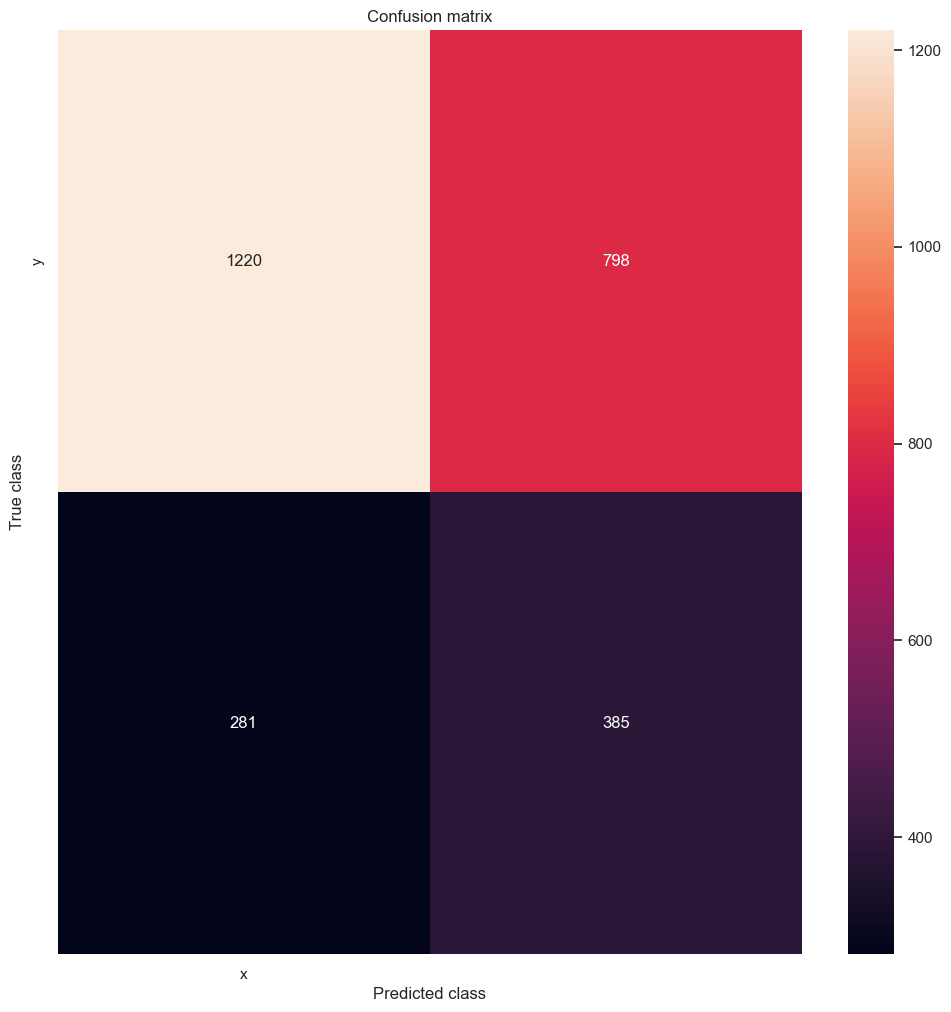

              precision    recall  f1-score   support

           0       0.81      0.60      0.69      2018
           1       0.33      0.58      0.42       666

    accuracy                           0.60      2684
   macro avg       0.57      0.59      0.55      2684
weighted avg       0.69      0.60      0.62      2684

AUC: 0.5913185236772948


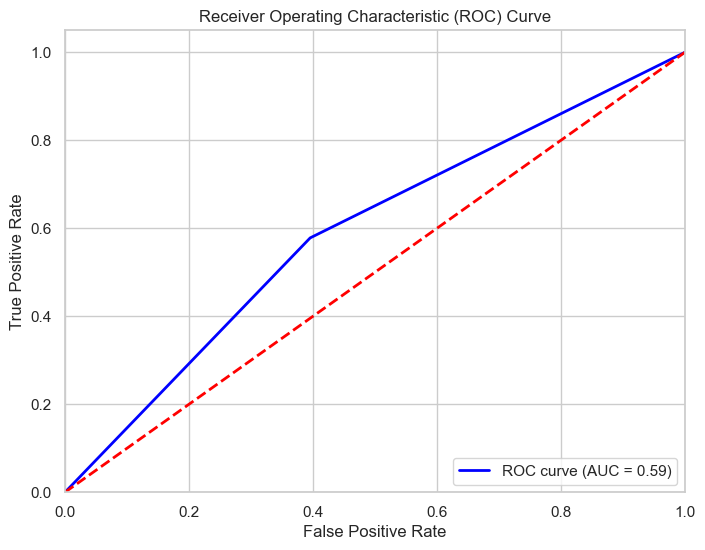

In [101]:
# Oversampling
os =  RandomOverSampler()
X_train_res_os, y_train_res_os = os.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution labels after resampling {}".format(Counter(y_train_res_os)))
 
# Modelo
model = run_model(X_train_res_os, X_val, y_train_res_os, y_val)

# Prediccion
pred_y = model.predict(X_val)

# Resultado
mostrar_resultados2(y_val, pred_y)

* **Smote-Tomek**

In [ ]:
from imblearn.combine import SMOTETomek

Procedemos a balancear los datos con la estrategia escogida.

In [ ]:
# Oversampling-Undersampling
os_us = SMOTETomek()
X_train_res_osus, y_train_res_osus = os_us.fit_resample(X_train, y_train)
 
print ("Distribution before resampling {}".format(Counter(y_train)))
print ("Distribution after resampling {}".format(Counter(y_train_res_osus)))

# Modelo
model = run_model(X_train_res_osus, X_val, y_train_res_osus, y_val)

# Prediccion
pred_y = model.predict(X_val)

# Resultados
mostrar_resultados(y_val, pred_y)

## Particionamiento final

In [102]:
# Librerias
import os

# Carpeta con datos
if not os.path.exists('Datos'):
    os.makedirs('Datos')
    
# Se guardan los datos
X_train.to_csv('Datos/X_train.csv', index=False)
X_val.to_csv('Datos/X_val.csv', index=False)
X_test.to_csv('Datos/X_test.csv', index=False)
y_train.to_csv('Datos/y_train.csv', index=False)
y_val.to_csv('Datos/y_val.csv', index=False)
y_test.to_csv('Datos/y_test.csv', index=False)